In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import IsolationForest
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

### Data Exploration

In [58]:
df = pd.read_csv('final_df.csv')
print('Dataset shape:', df.shape)
df.head()

Dataset shape: (723803, 25)


,fullVisitorId,FirstChannelVisit,LastChannelVisit,at_least_one_conversion,country,continent,subContinent,TotalVisits,TotalBounces,Organic Search,...,Display,(Other),TotalPageviews,desktop,mobile,tablet,FirstSessionPageviews,LastSessionPageviews,Conversion,CampaignVisits
0,4823595352351,Organic Search,Organic Search,0,China,Asia,Eastern Asia,1,1,1,...,0,0,1,1,0,0,1,1,0,0
1,5103959234087,Organic Search,Organic Search,0,United States,Americas,Northern America,1,0,1,...,0,0,8,0,1,0,8,8,0,0
2,10278554503158,Organic Search,Organic Search,0,New Zealand,Oceania,Australasia,1,0,1,...,0,0,8,1,0,0,8,8,0,0
3,20424342248747,Organic Search,Organic Search,0,Peru,Americas,South America,1,0,1,...,0,0,13,1,0,0,13,13,0,0
4,26722803385797,Organic Search,Organic Search,0,United Kingdom,Europe,Northern Europe,1,0,1,...,0,0,2,1,0,0,2,2,0,0


In [59]:
df.drop(['Conversion','fullVisitorId','country'],axis=1,inplace=True)
numeric_df = df.select_dtypes(include=['number'])
categorical_df = df.select_dtypes(include=['object'])

at_least_one_conversion
0    0.986027
1    0.013973
Name: proportion, dtype: float64


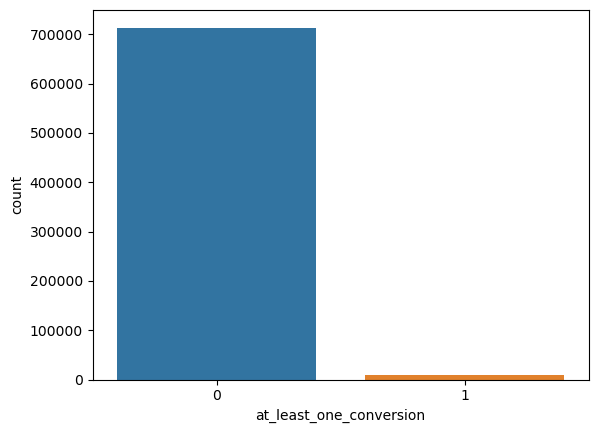

In [60]:
print(df['at_least_one_conversion'].value_counts(normalize=True))
sns.countplot(x=df['at_least_one_conversion']);

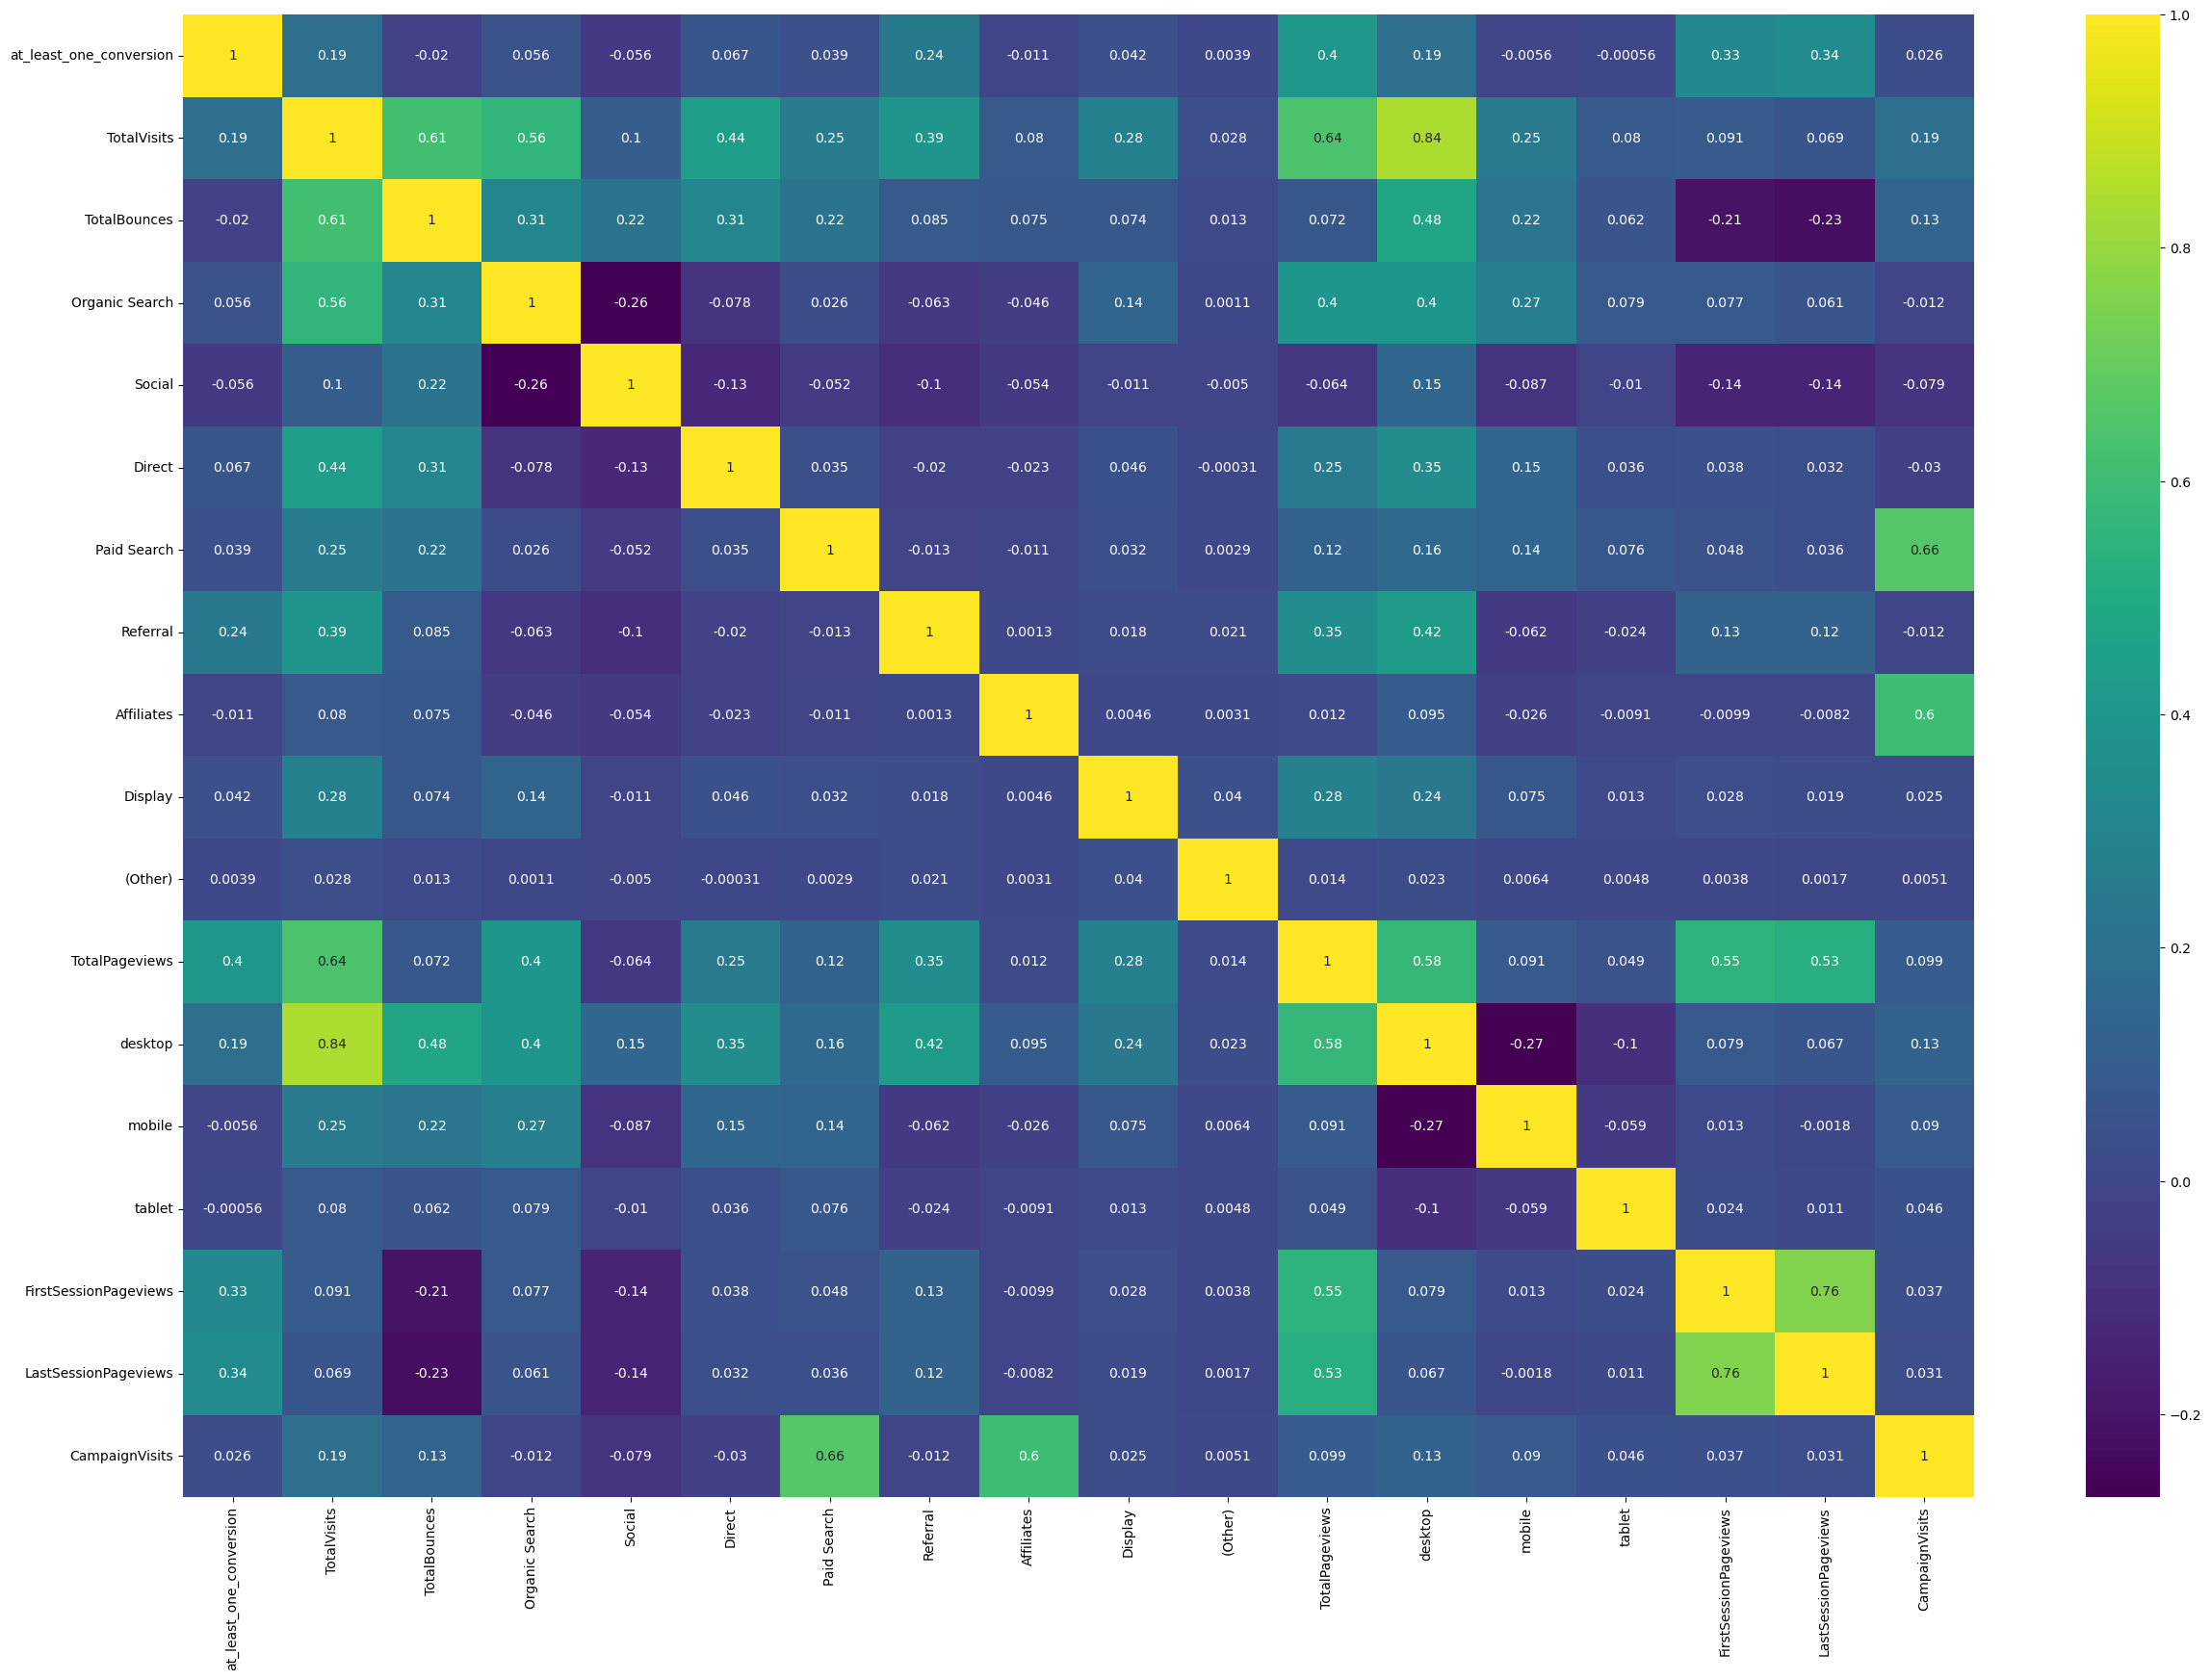

In [61]:
plt.figure(figsize=(30,20))
sns.heatmap(numeric_df.corr(),annot=True,cmap='viridis');

### Data Preprocess

In [62]:
df.drop(['TotalVisits','LastSessionPageviews'],axis=1,inplace=True)

In [63]:
df = pd.get_dummies(df, columns=categorical_df.columns, drop_first=True, dtype='int64')

In [64]:
print('Dataset shape:', df.shape)
df.head()

Dataset shape: (723803, 57)


,at_least_one_conversion,TotalBounces,Organic Search,Social,Direct,Paid Search,Referral,Affiliates,Display,(Other),...,subContinent_Northern Europe,subContinent_Polynesia,subContinent_South America,subContinent_Southeast Asia,subContinent_Southern Africa,subContinent_Southern Asia,subContinent_Southern Europe,subContinent_Western Africa,subContinent_Western Asia,subContinent_Western Europe
0,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [65]:
isolation_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
outlier_pred = isolation_forest.fit_predict(df)

In [70]:
print("Number of rows with outliers:", len(df)) 
df_inliers = df.iloc[outlier_pred == 1]

print("Number of rows without outliers:", len(df_inliers))
df_inliers.at_least_one_conversion.value_counts(normalize=True)

Number of rows with outliers: 723803
Number of rows without outliers: 687612


at_least_one_conversion
0    0.993284
1    0.006716
Name: proportion, dtype: float64

In [75]:
# create two different dataframe of majority and minority class 
df_majority = df_inliers[(df_inliers['at_least_one_conversion']==0)] 
df_minority = df_inliers[(df_inliers['at_least_one_conversion']==1)] 

# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 600000, # to match majority class
                                 random_state=42)  # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

In [76]:
X = df_upsampled.drop('at_least_one_conversion',axis=1)
y = df_upsampled['at_least_one_conversion']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [78]:
# Standardize the numerical values
scaler = StandardScaler()

non_binary = ['TotalBounces', 'Organic Search', 'Social', 'Direct', 'Paid Search', 'Referral', 'Affiliates', 'Display', 'TotalPageviews', 'desktop', 'mobile', 'tablet', 'FirstSessionPageviews', 'CampaignVisits']
X_train[non_binary] = scaler.fit_transform(X_train[non_binary])
X_test[non_binary] = scaler.transform(X_test[non_binary])

## Classification Models

In [80]:
# Define the models
models = {
    "RandomForest": RandomForestClassifier(), #n_estimators=100, max_depth=5
    "LogisticRegression": LogisticRegression(), #max_iter=1000
    "GradientBoosting": GradientBoostingClassifier(),
    "XGBOOST": XGBClassifier(), #n_estimators=100, max_depth=5
    "LightGBM": LGBMClassifier(verbose=-1) #n_estimators=100, max_depth=5, 
}

# Train and evaluate each model
model_scores = {}
for name, model in models.items():
    
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Store scores
    model_scores[name] = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}

# Display model performance
for model, scores in model_scores.items():
    print(f"Model: {model}")
    for score_name, score_value in scores.items():
        print(f"{score_name}: {score_value:.4f}")
    print("\n")

Model: RandomForest
Accuracy: 0.9780
Precision: 0.9619
Recall: 0.9923
F1 Score: 0.9768


Model: LogisticRegression
Accuracy: 0.9605
Precision: 0.9441
Recall: 0.9731
F1 Score: 0.9584


Model: GradientBoosting
Accuracy: 0.9659
Precision: 0.9448
Recall: 0.9845
F1 Score: 0.9642


Model: XGBOOST
Accuracy: 0.9728
Precision: 0.9524
Recall: 0.9913
F1 Score: 0.9715


Model: LightGBM
Accuracy: 0.9711
Precision: 0.9503
Recall: 0.9899
F1 Score: 0.9697


